In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import levene
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.feature_selection import SelectKBest, chi2
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from scipy.stats import ttest_rel
from sklearn.ensemble import VotingClassifier
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import ParameterGrid
from joblib import dump, load
from pickle import dump, load
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Analysis & Preprocessing

In [41]:
train_df = pd.read_excel('../data/AI_vs_huam_train_dataset.xlsx')
test_df = pd.read_csv('../data/Final_test_data.csv')

print('Training data shape:', train_df.shape)
print(train_df.head())

print('Test data shape:', test_df.shape)
print(test_df.head())

Training data shape: (3728, 2)
                                               essay  label
0  International sports events require the most w...      0
1  Globalisation has become a significant aspect ...      0
2  There is an ever-increasing number of bullying...      0
3  It is commonly believed, that companies should...      0
4  Despite knowing about the adverse effects of c...      0
Test data shape: (869, 2)
                                               essay  label
0  Enjoyment means entertainment, satisfaction of...    NaN
1  Before to start with my opinion of the topic i...    NaN
2  Thats a really really good subject, but acctul...    NaN
3  I disagree with the statement saying that it i...    NaN
4  It is undeniable that advertisements play a si...    NaN


In [42]:
#preprocessing
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if not re.fullmatch(r"\d+", t)]
    return " ".join(tokens)

def preprocess(text, method='lemmatization'):
    text = clean_text(text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    if method == 'stemming':
        tokens = [ps.stem(t) for t in tokens]
    else:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

print(preprocess('The COVID19 pandemic started in 2020!', method='lemmatization'))

covid pandemic started


feature extraction

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy


nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words
def remove_stopwords(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if token.text.lower() not in stop_words])
# Preprocess texts
train_clean = train_df['essay'].apply(remove_stopwords).tolist()

# TF-IDF Vectorization
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.8)
X_tfidf = tfidf.fit_transform(train_clean)

# Bag of Words
bow = CountVectorizer(ngram_range=(1,2), min_df=1, max_df=0.8)
X_bow = bow.fit_transform(train_clean)

In [44]:
bow = CountVectorizer(preprocessor=lambda x: preprocess(x, method='lemmatization'))
tfidf = TfidfVectorizer(preprocessor=lambda x: preprocess(x, method='lemmatization'))

In [45]:
# Split train/test
X = train_df['essay']
y = train_df['label']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model Development & Optimization

In [46]:
# SVM Pipeline and GridSearchCV
svm_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=preprocess)),
    ('classifier', SVC(probability=True, random_state=42))
])

svm_param_grid = {
    'vectorizer__max_features': [1000],
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01]
}

# Decision Tree Pipeline and GridSearchCV
dt_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=preprocess)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    'vectorizer__max_features': [1000],
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# AdaBoost Pipeline and GridSearchCV
ab_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(preprocessor=preprocess)),
    ('classifier', AdaBoostClassifier(random_state=42))
])

ab_param_grid = {
    # TF-IDF vectorizer hyperparameters
    'vectorizer__max_features': [1000, 2000],
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],

    # AdaBoost-specific hyperparameters
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.5, 1.0, 1.5],
    # Base estimator defaults to DecisionTree(max_depth=1),
    # but you can customize it via the `estimator` parameter:
    # 'classifier__estimator__max_depth': [1, 2, 3]

    # Control randomness for reproducibility
    'classifier__random_state': [42]
}

## Hyperparameter Optimization

In [47]:
svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, n_jobs=-1, verbose=1, refit=True)
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_params_
print('Best SVM parameters:', best_svm)
with open("../models/svm_model.pkl", 'wb') as f:
    dump(svm_grid.best_estimator_, f, protocol=5)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


Best SVM parameters: {'classifier__C': 100, 'classifier__gamma': 0.01, 'classifier__kernel': 'rbf', 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}


In [48]:
dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, n_jobs=-1, verbose=1, refit=True)
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_params_
print('Best Decision Tree parameters:', best_dt)
with open("../models/decision_tree_model.pkl", 'wb') as f:
    dump(dt_grid.best_estimator_, f, protocol=5)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Decision Tree parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 3)}


In [49]:
ab_grid = GridSearchCV(ab_pipeline, ab_param_grid, cv=5, n_jobs=-1, verbose=1, refit=True)
ab_grid.fit(X_train, y_train)
best_ab = ab_grid.best_params_
print('Best Decision Tree parameters:', best_ab)
with open("../models/adaboost_model.pkl", 'wb') as f:
    dump(ab_grid.best_estimator_, f, protocol=5)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Decision Tree parameters: {'classifier__learning_rate': 1.5, 'classifier__n_estimators': 200, 'classifier__random_state': 42, 'vectorizer__max_features': 2000, 'vectorizer__ngram_range': (1, 3)}


## Performance Evaluation & Analysis
K-fold and Stratified K-fold implementation

In [50]:
# K-Fold Cross-Validation
svm_cv_scores = cross_val_score(svm_grid.best_estimator_, X, y, cv=5)
dt_cv_scores = cross_val_score(dt_grid.best_estimator_, X, y, cv=5)
ab_cv_scores = cross_val_score(ab_grid.best_estimator_, X, y, cv=5)
print('SVM CV mean/std:', svm_cv_scores.mean(), svm_cv_scores.std())
print('DT CV mean/std:', dt_cv_scores.mean(), dt_cv_scores.std())
print('AB CV mean/std:', ab_cv_scores.mean(), ab_cv_scores.std())

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_strat_scores = cross_val_score(svm_grid.best_estimator_, X, y, cv=skf)
dt_strat_scores = cross_val_score(dt_grid.best_estimator_, X, y, cv=skf)
ab_strat_scores = cross_val_score(ab_grid.best_estimator_, X, y, cv=skf)
print('SVM Stratified CV mean/std:', svm_strat_scores.mean(), svm_strat_scores.std())
print('DT Stratified CV mean/std:', dt_strat_scores.mean(), dt_strat_scores.std())
print('AB Stratified CV mean/std:', ab_strat_scores.mean(), ab_strat_scores.std())

SVM CV mean/std: 0.9560217356100544 0.03012591270322444
DT CV mean/std: 0.8388041815859077 0.04050273378600317
AB CV mean/std: 0.9415398456195907 0.03453492232850392
SVM Stratified CV mean/std: 0.9554722277201 0.006587947997548865
DT Stratified CV mean/std: 0.8489788941468592 0.008910003055681029
AB Stratified CV mean/std: 0.9503762347733774 0.004478691949080778


#### Statistical analysis of model stability across folds

In [51]:
stat, p = levene(svm_cv_scores, dt_cv_scores, ab_cv_scores)
print('Levene test p-value:', p)
if p < 0.05:
    print("The variances are significantly different.")
else:
    print("The variances are not significantly different.")

Levene test p-value: 0.9349600257146234
The variances are not significantly different.


Statistical analysis of model stability across folds: we obtain accuracy scores for each fold using cross_val_score() as an array, as well as the coefficient of variance ratio of standard deviation over sample mean.

Compute performance metrics and plot ROC/Precision-Recall curves.

In [52]:
# Evaluate on validation set
models = {'SVM': svm_grid.best_estimator_, 'Decision Tree': dt_grid.best_estimator_}
for name, model in models.items():
    preds = model.predict(X_val)
    probs = model.predict_proba(X_val)[:,1]
    print(f"{name} Classification Report:")
    print(classification_report(y_val, preds))
    cm = confusion_matrix(y_val, preds)
    print(f"Confusion Matrix:\n{cm}")
    roc_auc = roc_auc_score(y_val, probs)
    print(f"ROC AUC: {roc_auc}\n")


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       373
           1       0.94      0.95      0.95       373

    accuracy                           0.95       746
   macro avg       0.95      0.95      0.95       746
weighted avg       0.95      0.95      0.95       746

Confusion Matrix:
[[351  22]
 [ 17 356]]
ROC AUC: 0.9883884740061382

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       373
           1       0.89      0.80      0.84       373

    accuracy                           0.85       746
   macro avg       0.86      0.85      0.85       746
weighted avg       0.86      0.85      0.85       746

Confusion Matrix:
[[338  35]
 [ 76 297]]
ROC AUC: 0.8739155747543647



In [53]:
# Evaluate on validation set
models = {'AdaBoost': ab_grid.best_estimator_}
for name, model in models.items():
    preds = model.predict(X_val)
    probs = model.predict_proba(X_val)[:,1]
    print(f"{name} Classification Report:")
    print(classification_report(y_val, preds))
    cm = confusion_matrix(y_val, preds)
    print(f"Confusion Matrix:\n{cm}")
    roc_auc = roc_auc_score(y_val, probs)
    print(f"ROC AUC: {roc_auc}\n")


AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       373
           1       0.94      0.95      0.94       373

    accuracy                           0.94       746
   macro avg       0.94      0.94      0.94       746
weighted avg       0.94      0.94      0.94       746

Confusion Matrix:
[[349  24]
 [ 20 353]]
ROC AUC: 0.9868539269311215



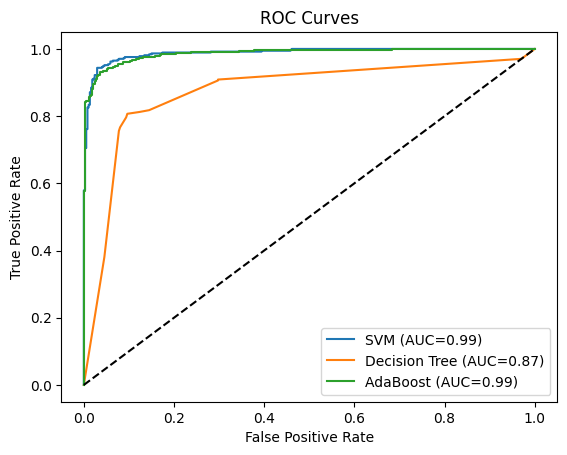

In [54]:
# Plot ROC curves
models = {'SVM': svm_grid.best_estimator_, 'Decision Tree': dt_grid.best_estimator_, 'AdaBoost': ab_grid.best_estimator_}
plt.figure()
for name, model in models.items():
    probs = model.predict_proba(X_val)[:,1]
    fpr, tpr, _ = roc_curve(y_val, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_val, probs):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Generate predictions on the test set and save to CSV.

#### Results summary and discussion
From the results above we can easily see that the best SVM and AdaBoost model outperform the best DT in this specific task with this specific dataset, since best SVM has higher accuracy, precision, recall and f-1 score than best DT.

### Deep Analysis
Statistical significance testing between SVM and Decision Tree CV scores.

H_null: SVM performance = DT performance  
H_alt: SVM performance != DT performance

In [56]:
svm_scores = cross_val_score(svm_grid.best_estimator_, X, y, cv=5)
dt_scores = cross_val_score(dt_grid.best_estimator_, X, y, cv=5)
t_stat, p_value = ttest_rel(svm_scores, dt_scores)
print(f'Paired t-test t-statistic: {t_stat:.3f}, p-value: {p_value:.3f}')

Paired t-test t-statistic: 21.237, p-value: 0.000


Based on the results of the t test we have sufficient evidence to reject the null hypothesis and that there is statistically significant difference between best SVM performance and best DT performance when classifying this specific dataset assigned to us in assignment 2. And from the positive 14 t statistic we know the best SVM performs much better at classfying human vs AI texts than the best DT model. the ROC curve as well as AUC score also corresponds to this point since SVM AUC score is much higher then the DT AUC score.